In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode

from PIL import Image

In [2]:
%load_ext rich
%load_ext autoreload
%autoreload 1

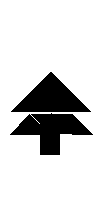

In [3]:
tangram = [[[0.50392557 ,0.50607443],
            [0.32714887 ,0.50607443],
            [0.50392557 ,0.68285113]],
            [[0.50607443, 0.50607443],
            [0.50607443 ,0.68285113],
            [0.68285113 ,0.50607443]],
            [[0.41      , 0.49392557],
            [0.49838835 ,0.40553722],
            [0.32161165 ,0.40553722]],
            [[0.50553722, 0.40753722],
            [0.50553722 ,0.49592557],
            [0.59392557 ,0.40753722]],
            [[0.50446278, 0.49446278],
            [0.50446278 ,0.40607443],
            [0.41607443 ,0.49446278]],
            [[0.45580583, 0.31580583],
            [0.45580583 ,0.40419417],
            [0.54419417 ,0.40419417],
            [0.54419417 ,0.31580583]],
            [[0.6       , 0.49419417],
            [0.51161165 ,0.49419417],
            [0.6        ,0.40580583],
            [0.68838835 ,0.40580583]]]

from cv2 import fillPoly

img = np.full((size := 224, 100), 255, dtype=np.uint8)
fillPoly(img, [[-62, size] + (np.asarray(polygon) * [size, -size]).astype(int) for polygon in tangram], color=0)
image = Image.fromarray(img)
image

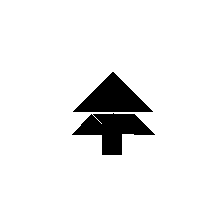

In [4]:
img_s = np.full((size := 224, size), 255, dtype=np.uint8)
fillPoly(img_s, [[0, size] + (np.asarray(polygon) * [size, -size]).astype(int) for polygon in tangram], color=0)
image_s = Image.fromarray(img_s)
image_s

In [5]:
img3 = np.tile(img[:, :, None], (1, 1, 3))

In [6]:
%%timeit
ToTensor()(img3)

89.6 µs ± 6.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
Image.fromarray(img)

5.76 µs ± 10.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### CLIP

In [8]:
import clip
%aimport clip

In [9]:
model, preprocess = clip.load('ViT-L/14')
preprocess


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa042a88e50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [10]:
tt = ToTensor()
cr = lambda image: image.convert("RGB")
nn = Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

In [11]:
%%timeit
preprocess(Image.fromarray(img))

1.26 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%%timeit
preprocess(image)

1.23 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%%timeit
preprocess(image.convert("RGB"))

1.9 ms ± 7.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
# Possible inputs to preprocess
# img
# img3

#### Grayscale

###### `broadcast_to` vs `tile` vs `repeat`

In [15]:
%%timeit
img3 = np.broadcast_to(img[:, :, None], img.shape + (3,)).copy()

146 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%%timeit
img3 = np.repeat(img[:, :, None], 3, axis=-1)

174 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%%timeit
img3 = np.tile(img, (1, 1, 3))

6.23 µs ± 95.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


---

In [18]:
%%timeit
np.tile(img, (3, 1, 1)).transpose(1, 2, 0)

6.02 µs ± 279 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
%%timeit
np.tile(img[:, :, None], (1, 1, 3))  # Tiling in the last dimension is bad

163 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


###### (`as_tensor()` vs `tensor()`) + (`torch(np.tile(...))` vs `torch.tile(torch)`)

In [20]:
%%timeit
torch.as_tensor(np.tile(img, (3, 1, 1)), dtype=torch.float)

25.1 µs ± 299 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
torch.tile(torch.as_tensor(img, dtype=torch.float), (3, 1, 1))

29.2 µs ± 358 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


---

In [22]:
%%timeit
torch.tensor(np.tile(img, (3, 1, 1)), dtype=torch.float)

25.5 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
%%timeit
torch.tile(torch.tensor(img, dtype=torch.float), (3, 1, 1))

30.3 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


##### Using `ToTensor()`

In [24]:
%%timeit
Compose([tt, nn])(np.tile((img), (3, 1, 1)).transpose(1, 2, 0))

177 µs ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
%%timeit
Compose([tt, nn])(Image.fromarray(img).convert("RGB"))

334 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


##### Using `tensor()`

> Winner (below) - Grayscale

In [26]:
%%timeit
Compose([nn])(torch.as_tensor(np.tile(img, (3, 1, 1)), dtype=torch.float))

142 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Colored

###### (`torch(np.transpose(...))` vs `torch.permute(torch(...))`)

In [27]:
%%timeit
torch.as_tensor(img3.transpose(2, 0, 1), dtype=torch.float32)

20.4 µs ± 303 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
%%timeit
torch.as_tensor(img3, dtype=torch.float32).permute(2, 0, 1)

23.8 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


##### Using `ToTensor()`

> Winner (below) - Colored

In [29]:
%%timeit
Compose([tt, nn])(img3)

186 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
%%timeit
Compose([tt, nn])(Image.fromarray(img3))

321 µs ± 717 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


##### Using `tensor()`

In [31]:
%%timeit
Compose([nn])(torch.as_tensor(img3.transpose(2, 0, 1), dtype=torch.float32) / 255)

217 µs ± 632 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
